# 유료회원 데이터분석 Project


#### 배경 및 목적
광고주 수 증감내역에 대한 시도별, 월별 상세 자료를 가공 및 분석하고,   
기존, 신규인입 광고주들의 계약 유지율과,탈락률을 파악함.   
신규, 탈락 과의 상관분석과, 둘 사이의 선형방정식을 통해 시뮬레이션 및 분석과 예측을 하고자 함


#### 핵심기법
데이터로드 및 저장, 전처리, 표준화, 시각화, 분석




#### 용어설명 
전일데이터 : 이전 데이터    
당일데이터 : 현재 데이터
신규 : 해당 기간 내 새로 인입되어 유지중인 광고주     
탈락신규 : 해당 기간 내 새로 인입되었으나 현재는 상품 N     
실제유지 : 1/1 시점에도 있었는데, 현재도 유지중인 광고주 (중간에 일정 탈락 기간이 존재할 수 있음)     
탈락 : 1/1 시점에 존재했으나 현재는 상품 N     
1/1(전일데이터) 시점의 광고주수는 실제유지 + 탈락 = 15057     
9/28(당일데이터) 시점의 광고주수는 실제유지 + 신규 = 16023    

## 필요한 모듈세팅

In [1]:
#데이터 로드 및 저장
from pandas import ExcelFile                     #엑셀파일 load
from pandas import ExcelWriter                   #엑셀파일 write
import os                                        #데이터 저장경로설정
from openpyxl import load_workbook               #엑셀파일 내부가공


#데이터 전처리
from pandas import DataFrame                     #데이터 프레임을 다루기 
from pandas import concat                        #데이터프레임 단순결합
from pandas import merge                         #데이터프레임 조건결합(공통 등등)
from datetime import datetime                    #시계열 데이터 분석 및 가공
from datetime import date, timedelta             #시계열 데이터 분석 및 가공
from IPython.display import display_html         #데이터 프레임 나란히 출력

#데이터 시각화 및 분석
import numpy                                     #행렬, 공학용계산
from IPython.display import SVG                  #지도svg 파일사용
from bs4 import BeautifulSoup                    #svg파일가공
from matplotlib import pyplot                    #시각화 그래프 출력
import seaborn as sns                            #시각화 그래프 출력
from sklearn.preprocessing import StandardScaler #선형회귀 공식을 사용하기위해 자료를 표준화
import tensorflow as tf                          #선형회귀로 예측


#기타
import warnings                                  #warning메시지 생략
warnings.filterwarnings(action='ignore')

## 데이터 로드

#### 엑셀파일 불러오기( 전일데이터, 당일데이터)


In [2]:
#엑셀파일 불러오기(전일)
xls_org = ExcelFile(r'/Users/donut/더비즈/광고주수증가/datahouse/포커스_2020-01-01.xlsx')
#엑셀파일 불러오기(당일)
xls_copy = ExcelFile(r'/Users/donut/더비즈/광고주수증가/datahouse/포커스_2020-09-28v2.xlsx')

#### 데이터 load 확인

In [3]:
#전일 파일 시트 명, 시트 수 확인
print(xls_org.sheet_names)
#당일 파일 시트 명, 시트 수 확인
print(xls_copy.sheet_names)

['Sheet2', 'Sheet3']
['Sheet3', 'Sheet2', 'Sheet1']


#### 데이터프레임 생성 및 shape, 결측치확인

In [4]:
#전일 데이터프레임생성하기
df_org = xls_org.parse(xls_org.sheet_names[0])
print(df_org.shape)
print(df_org.isnull().sum())

(67050, 20)
순번             0
회원번호           0
가입금액           0
영업대행사          0
가입시작일          0
가입만료일          0
상태             0
등록일자           0
영업사원아이디        0
영업사원명          0
sido           0
gugun          0
bubdong        0
관리담당자          0
종료구분           0
계약구분3          0
결제번호           0
실제시작일          0
실제종료일          0
test판단     66929
dtype: int64


In [5]:
#당일 데이터프레임 생성하기
df_copy = xls_copy.parse(xls_copy.sheet_names[2])
print(df_copy.shape)
print(df_copy.isnull().sum())

(59205, 88)
순번              0
계약구분            0
회원번호            0
가입금액            0
장바구니결제금액    19173
            ...  
직전계약실만기월    22525
분기              0
권역구분2           0
요일구분            0
영업일구분           0
Length: 88, dtype: int64


## 데이터 전처리
####  데이터프레임 정렬 및 결측치 처리
#### 결측치(빈칸)은 결측으로 표시하게 만들었음.
#### 등록중인 매물은 종료구분이 빈칸이며, test판단도 정상 매물은 빈칸임.

In [6]:
#데이터 프레임을 옆으로 표시하기위해 미리 함수를 설정한다.
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)


In [7]:
#전일 사용할 컬럼만 불러오기
df_org = df_org.reindex(columns=['순번','회원번호','가입금액','영업대행사','관리담당자','영업사원명','상태','sido','gugun','종료구분','계약구분3','실제시작일','실제종료일','계약일자','test판단'])
df_org.dropna(subset=['회원번호'], inplace = True)
#전일 데이터 프레임 결측치 처리
df_org_change = df_org.fillna(value="결측")
df_org_change.isnull().sum()

순번        0
회원번호      0
가입금액      0
영업대행사     0
관리담당자     0
영업사원명     0
상태        0
sido      0
gugun     0
종료구분      0
계약구분3     0
실제시작일     0
실제종료일     0
계약일자      0
test판단    0
dtype: int64

In [8]:
#당일 사용할 컬럼만 불러오기
df_copy = df_copy.reindex(columns=['순번','회원번호','가입금액','영업대행사','관리담당자','영업사원명','상태','sido','gugun','종료구분','계약구분3','실제시작일','실제종료일','계약일자','test판단'])
df_copy.dropna(subset=['회원번호'], inplace = True)
#당일 데이터 프레임 결측치 처리
df_copy_change = df_copy.fillna(value="결측")
df_copy_change.isnull().sum()

순번        0
회원번호      0
가입금액      0
영업대행사     0
관리담당자     0
영업사원명     0
상태        0
sido      0
gugun     0
종료구분      0
계약구분3     0
실제시작일     0
실제종료일     0
계약일자      0
test판단    0
dtype: int64

### 기준일 세팅 
시계열 데이터를 처리하기위해 시간 관련 데이터를 정의   

In [9]:
now = datetime.now()
year = '%s'%(now.year)
month ='%s'%(now.month)
month=month.rjust(2,'0')
day = '%s'%(now.day)
day=day.rjust(2,'0')
today = f'{year}-{month}-{day}'
#today1 =f"실제종료일 != '{today}'"

#01.01 비교시 사용
dday =datetime(2020,1,1)

#하루전 비교 사용
#dday = datetime.today() - timedelta(days =1)

daylen = datetime.today() - datetime(2020,1,1)

item = []
for i in range(daylen.days+1):    
    date=datetime.today()-timedelta(days = i)
    item.append(date.strftime('%Y-%m-%d'))
    i+=1

####  무효건(실제시작일>=실제종료일) 제거하기_20200924추가

In [10]:
#전일원장

무효시작일ls =list(df_org_change['실제시작일'])
무효종료일ls =list(df_org_change['실제종료일'])
무효시작변환 = []
무효종료변환 = []

for i in range(len(무효시작일ls)):
    무효시작변환.append(datetime(int(무효시작일ls[i][:4]),int(무효시작일ls[i][5:7]),int(무효시작일ls[i][8:])))
for i in range(len(무효종료일ls)):
    무효종료변환.append(datetime(int(무효종료일ls[i][:4]),int(무효종료일ls[i][5:7]),int(무효종료일ls[i][8:])))
            
무효체크 = []

for i in range(len(무효시작변환)):
    if 무효종료변환[i]<=무효시작변환[i]:
        무효체크.append("무효")
    else:
        무효체크.append("유효")
df_org_change['무효체크'] = 무효체크
df_org_change.query('무효체크 =="유효"',inplace=True)
print(df_org_change.shape)
df_org_change.head()

(66343, 16)


,순번,회원번호,가입금액,영업대행사,관리담당자,영업사원명,상태,sido,gugun,종료구분,계약구분3,실제시작일,실제종료일,계약일자,test판단,무효체크
0,236005,1,473000,A기업,김,김,계약만료,경기,파주시,소진,0,2018-03-02,2018-08-30,결측,결측,유효
1,259587,1,473000,A기업,김,김,계약만료,경기,파주시,만료,만기재계약,2018-08-30,2019-02-27,결측,결측,유효
2,281353,1,473000,A기업,김,김,계약만료,경기,파주시,소진,만기재계약,2019-02-28,2019-07-26,결측,결측,유효
3,299671,1,473000,A기업,김,김,등록중,경기,파주시,0,소진재계약,2019-07-26,2020-01-25,결측,결측,유효
4,234283,3,352000,B기업,김,김,계약만료,서울,종로구,만료,0,2018-02-19,2018-08-18,결측,결측,유효


In [11]:
#당일원장

무효시작일ls =list(df_copy_change['실제시작일'])
무효종료일ls =list(df_copy_change['실제종료일'])
무효시작변환 = []
무효종료변환 = []

for i in range(len(무효시작일ls)):
    무효시작변환.append(datetime(int(무효시작일ls[i][:4]),int(무효시작일ls[i][5:7]),int(무효시작일ls[i][8:])))
for i in range(len(무효종료일ls)):
    무효종료변환.append(datetime(int(무효종료일ls[i][:4]),int(무효종료일ls[i][5:7]),int(무효종료일ls[i][8:])))
    
    
    
    
무효체크 = []
for i in range(len(무효시작변환)):
    if 무효종료변환[i]<=무효시작변환[i]:
        무효체크.append("무효")
    else:
        무효체크.append("유효")
df_copy_change['무효체크'] = 무효체크
df_copy_change.query('무효체크 =="유효"',inplace=True)
print(df_copy_change.shape)
df_copy_change.head()

(58623, 16)


,순번,회원번호,가입금액,영업대행사,관리담당자,영업사원명,상태,sido,gugun,종료구분,계약구분3,실제시작일,실제종료일,계약일자,test판단,무효체크
0,281353,1,473000,A기업,김,김,계약만료,경기,파주시,소진,만기재계약,2019-02-28,2019-07-26,2019-02-21,결측,유효
1,299671,1,473000,A기업,김,김,계약만료,경기,파주시,만료,소진재계약,2019-07-26,2020-01-25,2019-07-23,결측,유효
2,321174,1,473000,A기업,김,김,계약만료,경기,파주시,소진,만기재계약,2020-01-26,2020-06-24,2020-01-21,결측,유효
3,339515,1,473000,A기업,김,김,등록중,경기,파주시,결측,소진재계약,2020-06-24,2020-12-23,2020-06-16,결측,유효
4,280642,3,352000,B기업,김,김,계약만료,서울,종로구,만료,만기재계약,2019-02-19,2019-08-18,2019-02-18,결측,유효


#### 포커스 데이터프레임에서 필요한 값들만 불러오기
##### 전일과 당일의 등록중인 광고주 리스트를 비교하기위해 [등록중,유료가입,정상회원]의 데이터 프레임 설정

In [12]:
#포커스전일 등록중 데이터프레임 설정하기.
df_org_check = df_org_change.query('상태=="등록중" and 가입금액 >0 and test판단 =="결측"')

In [13]:
#2020-09-15 추가
df_org_check2 = df_org_check.filter(['회원번호','영업대행사','관리담당자','영업사원명'])
df_org_check2.rename(columns={'회원번호' : '회원번호_x',
                              '영업대행사' : '이전영업대행사',
                              '관리담당자': '이전관리담당자',
                             '영업사원명': '이전영업사원명'},inplace= True)

In [14]:
#포커스당일 등록중 데이터프레임 설정하기.
df_copy_check = df_copy_change.query('상태=="등록중" and 가입금액 >0 and test판단 =="결측"')
#2020.09.16 추가
df_copy_check2 = df_copy_change.query('상태!="등록중" and 가입금액 >0 and test판단 =="결측"')
df_copy_empoly = df_copy_change.query('가입금액 >0 and test판단 =="결측"')

## 초기 광고주수 확인

In [15]:
초기광고주수 = df_org_check.shape[0]
현재광고주수 = df_copy_check.shape[0]
변화량 = 현재광고주수 - 초기광고주수


print("[광고주 수]")
print("1/1 기준 광고주 수 : " ,초기광고주수 )
print("9/28 기준 광고주 수 : " ,현재광고주수)
print("광고주 수  " , 변화량,"변화" )

[광고주 수]
1/1 기준 광고주 수 :  15057
9/28 기준 광고주 수 :  16027
광고주 수   970 변화


## 신규탈락리스트 구하기

In [16]:
실제시작일ls =list(df_copy_check2['실제시작일'])
실시작변환 = []

for i in range(len(실제시작일ls)):
    실시작변환.append(datetime(int(실제시작일ls[i][:4]),int(실제시작일ls[i][5:7]),int(실제시작일ls[i][8:])))
    
실제시작일체크 = []
for i in range(len(실시작변환)):
    if dday<=실시작변환[i]:
        실제시작일체크.append("유효")
    else:
        실제시작일체크.append("삭제")
        
df_copy_check2['실제시작일_변환'] = 실제시작일체크
df_copy_check3 = df_copy_check2.query('실제시작일_변환 == "유효"')
df_copy_check4=df_copy_check3.filter(['회원번호','가입금액'])

#이전과 현재 등록중이였던것은 신규탈락에 포함되지 않음으로 제거해야함
df_copy_check5=df_copy_check4.join(df_org_check.set_index('회원번호')['상태'],on='회원번호')
orgls=list(df_copy_check5['상태'])
df_copy_check5=df_copy_check4.join(df_copy_check.set_index('회원번호')['상태'],on='회원번호')
copyls=list(df_copy_check5['상태'])


df_copy_check4['현재상태'] = copyls
df_copy_check4['이전상태'] = orgls
df_copy_check6=df_copy_check4.query('현재상태 !="등록중" and 이전상태 != "등록중"')

#회원번호 중복제거
df_copy_check6.drop_duplicates(['회원번호'],inplace=True)
df_copy_check7= df_copy_check6.filter(['회원번호','가입금액','현재상태'])
df_copy_check7.rename(columns={'현재상태': '상태'},inplace=True)


df_copy_check8=df_copy_check7.query('상태 != "등록중"')
df_copy_check8['가입금액'] = "신규탈락"
df_copy_check8.rename(columns={'가입금액': '구분'},inplace=True)
df_copy_check9 = df_copy_check8.filter(['회원번호','구분'])
신규탈락리스트 =df_copy_check9.join(df_copy_check3.set_index('회원번호')['순번'],on='회원번호')
신규탈락리스트2 = merge(신규탈락리스트,df_copy_check3, on=['순번'])
신규탈락리스트2.drop_duplicates(['회원번호_x'],keep='last',inplace=True)

신규인덱스 = list(신규탈락리스트2.index)
#회원본호 컬럼을 리스트로 추출
회원번호_x = list(신규탈락리스트2['회원번호_x'])
#딕셔너리로 묶기
indexDict1={}
for i, v in enumerate(회원번호_x):
    before = 신규인덱스[i];
    indexDict1[before] = v
#추출결과를 데이터 프레임에 반영
신규탈락리스트2.rename(index=indexDict1, inplace=True)

#필요없는 컬럼 삭제
#신규리스트2.drop(['회원번호_x','회원번호_y','종료구분','test판단'], axis=1, inplace=True)
#신규리스트2
#필요없는 컬럼 삭제(수정 20200720, 종료구분은 삭제하지않았음, 원장을 신규,탈락으로 나누지않고 하나로 합치기위해 )
신규탈락리스트2.drop(['회원번호_x','회원번호_y','test판단','실제시작일_변환'], axis=1, inplace=True)
print(신규탈락리스트2.shape)
신규탈락리스트2.head()

(711, 15)


,구분,순번,가입금액,영업대행사,관리담당자,영업사원명,상태,sido,gugun,종료구분,계약구분3,실제시작일,실제종료일,계약일자,무효체크
733,신규탈락,328818,352000,A기업,김,김,계약만료,서울,동작구,만료,기존신규,2020-03-23,2020-09-22,2020-03-23,유효
777,신규탈락,324710,231000,A기업,김,김,계약만료,서울,마포구,만료,기존신규,2020-02-19,2020-08-18,2020-02-19,유효
879,신규탈락,328214,473000,B기업,김,김,계약만료,서울,중랑구,만료,기존신규,2020-03-17,2020-09-16,2020-03-17,유효
1011,신규탈락,325162,231000,A기업,김,김,계약만료,서울,은평구,소진,기존신규,2020-02-24,2020-06-03,2020-02-24,유효
1073,신규탈락,324893,352000,A기업,김,김,계약만료,경기,평택시,환불,기존신규,2020-02-20,2020-03-25,2020-02-20,유효


## 신규,탈락 비교를 위한 작업데이터 프레임 생성하기

#### 전일과 당일, [회원번호], [순번,회원번호] 데이터를 포함한 데이터 프레임 생성하기

In [17]:
#포커스 전일 [회원번호] 데이터프레임 생성
df_org_work1 = df_org_check.reindex(columns=['회원번호'])
print(df_org_work1.shape)

#포커스전일 [순번,회원번호] 데이터프레임 생성
df_org_work2 = df_org_check.reindex(columns=['순번','회원번호'])
print(df_org_work2.shape)

#포커스당일 [회원번호] 데이터프레임 생성
df_copy_work1 = df_copy_check.reindex(columns=['회원번호'])
print(df_copy_work1.shape)

#포커스당일 [순번,회원번호] 데이터프레임 생성
df_copy_work2 = df_copy_check.reindex(columns=['순번','회원번호'])
print(df_copy_work2.shape)


display_side_by_side(df_org_work1.head(),df_org_work2.head(),df_copy_work1.head(),df_copy_work2.head())

(15057, 1)
(15057, 2)
(16027, 1)
(16027, 2)


회원번호 
 
 
 
 
 3 
 1 
 
 
 7 
 3 
 
 
 11 
 4 
 
 
 15 
 6 
 
 
 19 
 7 
 
 
 
 
 
 
 순번 
 회원번호 
 
 
 
 
 3 
 299671 
 1 
 
 
 7 
 302123 
 3 
 
 
 11 
 302745 
 4 
 
 
 15 
 300695 
 6 
 
 
 19 
 297465 
 7 
 
 
 
 
 
 
 회원번호 
 
 
 
 
 3 
 1 
 
 
 7 
 3 
 
 
 11 
 4 
 
 
 15 
 6 
 
 
 24 
 9 
 
 
 
 
 
 
 순번 
 회원번호 
 
 
 
 
 3 
 339515 
 1 
 
 
 7 
 347111 
 3 
 
 
 11 
 347220 
 4 
 
 
 15 
 342495 
 6 
 
 
 24 
 352074 
 9

## 데이터프레임 조합하여, 신규, 탈락 리스트 만들기

#### [회원번호] 프레임에 전일A, 당일B라는 컬럼 붙여주기

In [18]:
#포커스전일 [회원번호] 데이터프레임 복사
df_org_add=df_org_work1.copy()
print(df_org_add.shape)

#포커스전일 [회원번호] 데이터프레임에 A 컬럼 붙여주기
df_org_add['구분'] = 'A'
print(df_org_add.shape)

#포커스당일 [회원번호] 데이터프레임 복사
df_copy_add=df_copy_work1.copy()
print(df_copy_add.shape)

#포커스당일 [회원번호] 데이터프레임에 B 컬럼 붙여주기
df_copy_add['구분'] = 'B'
print(df_copy_add.shape)

display_side_by_side(df_org_add.head(),df_org_add.head(),df_copy_add.head(),df_copy_add.head())

(15057, 1)
(15057, 2)
(16027, 1)
(16027, 2)


,회원번호,구분
3,1,A
7,3,A
11,4,A
15,6,A
19,7,A
,회원번호,구분
3,1,A
7,3,A
11,4,A
15,6,A


## 탈락리스트 구하기

### 결측회원 선별하기

#### 당일->전일로 데이터를 결합하면, 결측치 발생
#### 전일엔 있었으나, 당일엔 "삭제된" 것들이 결측치며, 탈락으로 간주가능


In [19]:
#두 데이터 결합하기
# merge =결합하는 함수
# how='outer' 공통 컬럼의 값이 한쪽에만 있어도 데이터를 보여줌
# 전일데이타[회원번호], 당일데이타[회워번호,구분(B)]의 결합
# 전일존재한 회원번호가 당일에도 존재한다면B가 붙을 것이고, 존재 하지않으면 결측치가 됨

df_A=merge(df_org_work1, df_copy_add, how='outer')
print(df_A.shape)
df_A.head()

#결측치를 '탈락'으로 변환해줌
df_A_탈락 = df_A.fillna(value="탈락")
print(df_A_탈락.shape)
df_A_탈락.head()

# 탈락인 회원번호들만 선별함
df_A_탈락_선별 = df_A_탈락.query('구분 == "탈락"')
print(df_A_탈락_선별.shape)
df_A_탈락_선별.head()


#선별한 회원번호를 탈락 리스트로 데이터 프레임으로 만들기
#탈락 선별된 회원들은 전일 등록중이였음으로, 전일의 포커스 순번을 대입해준다.
#join은 엑셀의 브이룩업 같은 역활
탈락리스트1=df_A_탈락_선별.join(df_org_work2.set_index('회원번호')['순번'],on='회원번호')
print(탈락리스트1.shape)

#탈락회원의 모든 포커스정보 join_20200925
#탈락리스트1=df_A_탈락_선별.join(df_org_change.set_index('회원번호')['순번'],on='회원번호')
#탈락리스트1

display_side_by_side(df_A.head(),df_A_탈락.head(),df_A_탈락_선별.head(),탈락리스트1.head())

(18872, 2)
(18872, 2)
(2845, 2)
(2845, 3)


,회원번호,구분
0,1,B
1,3,B
2,4,B
3,6,B
4,7,NaN
,회원번호,구분
0,1,B
1,3,B
2,4,B
3,6,B


In [20]:
#포커스순번을 기준으로 당일의 데이터 프레임에서로 정보를 결합해 준다.
탈락리스트2 = merge(탈락리스트1,df_copy_change, on=['순번'])
print(탈락리스트2.shape)
탈락리스트2.head()

(2845, 18)


,회원번호_x,구분,순번,회원번호_y,가입금액,영업대행사,관리담당자,영업사원명,상태,sido,gugun,종료구분,계약구분3,실제시작일,실제종료일,계약일자,test판단,무효체크
0,7,탈락,297465,7,352000,B기업,김,김,계약만료,경기,성남시 수정구,만료,만기재계약,2019-07-12,2020-01-11,2019-07-04,결측,유효
1,55,탈락,315117,55,352000,B기업,김,김,계약만료,서울,노원구,환불,만기재계약,2019-11-30,2020-03-10,2019-11-27,결측,유효
2,95,탈락,316962,95,231000,B기업,김,김,계약만료,서울,구로구,만료,기존신규,2019-12-13,2020-06-12,2019-12-13,결측,유효
3,123,탈락,305098,123,352000,B기업,김,김,계약만료,경기,고양시 덕양구,환불,만기재계약,2019-09-06,2020-01-07,2019-09-05,결측,유효
4,126,탈락,299520,126,352000,A기업,김,김,계약만료,경기,김포시,만료,만기재계약,2019-07-23,2020-01-22,2019-07-22,결측,유효


## 유지리스트 구하기(2020.09.15추가)

### 유지회원 선별하기

#### 당일->전일로 데이터를 결합하면, 결측치 발생, (전일O 당일X -> 결측 =탈락)
#### 당일엔 존재, 전일존재 하는것

In [21]:
df_C=merge(df_org_work1, df_copy_add)
df_C_유지 = df_C.fillna(value="탈락")
df_C_유지_선별 = df_C_유지.query('구분 != "탈락"')
df_C_유지_선별['구분'] = "C"
유지리스트1=df_C_유지_선별.join(df_copy_work2.set_index('회원번호')['순번'],on='회원번호')
유지리스트2 = merge(유지리스트1,df_copy_change, on=['순번'])
유지리스트3 = merge(유지리스트2,df_org_check2, on=['회원번호_x'])


#인덱스 이름 바꾸기 rename()함수사용

#인덱스를 리스트로 추출
신규인덱스 = list(유지리스트3.index)
#회원본호 컬럼을 리스트로 추출
회원번호_x = list(유지리스트3['회원번호_x'])
#딕셔너리로 묶기
indexDict1={}
for i, v in enumerate(회원번호_x):
    before = 신규인덱스[i];
    indexDict1[before] = v
#추출결과를 데이터 프레임에 반영
유지리스트3.rename(index=indexDict1, inplace=True)

#필요없는 컬럼 삭제
#신규리스트2.drop(['회원번호_x','회원번호_y','종료구분','test판단'], axis=1, inplace=True)
#신규리스트2
#필요없는 컬럼 삭제(수정 20200720, 종료구분은 삭제하지않았음, 원장을 신규,탈락으로 나누지않고 하나로 합치기위해 )
유지리스트3.drop(['회원번호_x','회원번호_y','test판단'], axis=1, inplace=True)
유지리스트3['구분'] = "유지"

#실제 당일 시작된 유지건들만 추리기(20200921추가)
유지리스트4= 유지리스트3.query('실제시작일 in @item')
유지리스트4['구분'] = "실제유지"
print(유지리스트4.shape)
유지리스트4.head()

(12212, 18)


,구분,순번,가입금액,영업대행사,관리담당자,영업사원명,상태,sido,gugun,종료구분,계약구분3,실제시작일,실제종료일,계약일자,무효체크,이전영업대행사,이전관리담당자,이전영업사원명
1,실제유지,339515,473000,A기업,김,김,등록중,경기,파주시,결측,소진재계약,2020-06-24,2020-12-23,2020-06-16,유효,A기업,김,김
3,실제유지,347111,352000,B기업,김,김,등록중,서울,종로구,결측,만기재계약,2020-08-19,2021-02-18,2020-08-18,유효,B기업,김,김
4,실제유지,347220,352000,B기업,김,김,등록중,서울,관악구,결측,만기재계약,2020-08-19,2021-02-18,2020-08-18,유효,B기업,김,김
6,실제유지,342495,352000,B기업,김,김,등록중,서울,관악구,결측,만기재계약,2020-08-01,2021-01-31,2020-07-10,유효,B기업,김,김
9,실제유지,352074,231000,B기업,김,김,등록중,서울,송파구,결측,만기재계약,2020-09-27,2021-03-26,2020-09-23,유효,B기업,김,김


## 신규리스트 구하기

### 신규회원 선별하기

#### 전일->당일로 데이터를 결합하면, 결측치 발생
#### 당일엔 존재하나, 전일엔 "없었던" 것들이 결측치며, 신규로 간주가능

In [22]:
#두 데이터 결합하기
# merge =결합하는 함수
# how='outer' 공통 컬럼의 값이 한쪽에만 있어도 데이터를 보여줌
# 당일데이타[회원번호], 전일데이타[회워번호,구분(B)]의 결합
# 당일존재하는 회원번호가 전일에도 존재한다면A가 붙을 것이고, 존재 하지않으면 결측치가 됨
df_B=merge(df_copy_work1, df_org_add, how='outer')
print(df_B.shape)

#결측치를 '신규'으로 변환해줌
df_B_신규 = df_B.fillna(value="신규")
print(df_B_신규.shape)

# 신규인 회원번호들만 선별함
df_B_신규_선별 = df_B_신규.query('구분 == "신규"')
print(df_B_신규_선별.shape)

### 선별한 회원번호를 탈락 리스트로 데이터 프레임으로 만들기
### 신규회원들의 최초 계약포커스 순번정보를 붙여준다(20200922추가)
# 신규 선별된 회원들은 당일 등록중이였음으로, 당일의 포커스 순번을 대입해준다.
#신규리스트1=df_B_신규_선별.join(df_copy_work2.set_index('회원번호')['순번'],on='회원번호')
#신규리스트1
#20200922 추가내용
#신규리스트1=df_B_신규_선별.join(df_copy_change.set_index('회원번호')['순번'],on='회원번호')
#신규리스트1.drop_duplicates(['회원번호'],inplace=True)
#20200924 추가내용
신규리스트1=df_B_신규_선별.join(df_copy_change.set_index('회원번호')['순번'],on='회원번호')
신규리스트1=신규리스트1.join(df_copy_change.set_index('순번')['실제시작일'],on='순번')
신규리스트1.query('실제시작일 in @item',inplace=True)
신규리스트1.drop('실제시작일',axis=1,inplace=True)
신규리스트1.drop_duplicates(['회원번호'],inplace=True)
print(신규리스트1.shape)

display_side_by_side(df_B.head(),df_B_신규.head(),df_B_신규_선별.head(),신규리스트1.head())

(18872, 2)
(18872, 2)
(3815, 2)
(3815, 3)


,회원번호,구분
0,1,A
1,3,A
2,4,A
3,6,A
4,9,A
,회원번호,구분
0,1,A
1,3,A
2,4,A
3,6,A


In [23]:
#포커스순번을 기준으로 당일의 데이터 프레임에서로 정보를 결합해 준다.
신규리스트2 = merge(신규리스트1,df_copy_change, on=['순번'])
#신규리스트2.query("실제종료일 == '2020-09-15'")
#신규리스트3 = 신규리스트2.query(today)
신규리스트3=신규리스트2.copy()
print(신규리스트3.shape)
신규리스트3.head()



(3815, 18)


,회원번호_x,구분,순번,회원번호_y,가입금액,영업대행사,관리담당자,영업사원명,상태,sido,gugun,종료구분,계약구분3,실제시작일,실제종료일,계약일자,test판단,무효체크
0,21,신규,335761,21,352000,B기업,김,김,등록중,경기,수원시 영통구,결측,기존신규,2020-05-15,2020-11-14,2020-05-15,결측,유효
1,51,신규,334483,51,231000,B기업,김,김,등록중,경기,성남시 분당구,결측,기존신규,2020-05-07,2020-11-06,2020-05-07,결측,유효
2,85,신규,332960,85,352000,B기업,김,김,등록중,서울,성북구,결측,기존신규,2020-04-24,2020-10-23,2020-04-24,결측,유효
3,89,신규,348776,89,726000,B기업,김,김,등록중,서울,노원구,결측,기존신규,2020-08-28,2021-02-27,2020-08-28,결측,유효
4,113,신규,333421,113,473000,B기업,김,김,등록중,경기,김포시,결측,기존신규,2020-04-28,2020-10-27,2020-04-28,결측,유효


### 추출된 리스트들을 정리하기
#### 1.인덱스를 회원번호_x로 바꾸고 이름을 바꿔준다,
#### 2.필요없는 컬럼들을 삭제해준다.
##### 2-1. 신규리스트에서는 회원본호_x~y, 종료구분, test판단을삭제
##### 2-2. 탈락리스트에서는 회원번호_x~y, test판단을 삭제해준다.

In [24]:
#인덱스 이름 바꾸기 rename()함수사용

#인덱스를 리스트로 추출
신규인덱스 = list(신규리스트3.index)
#회원본호 컬럼을 리스트로 추출
회원번호_x = list(신규리스트3['회원번호_x'])
#딕셔너리로 묶기
indexDict1={}
for i, v in enumerate(회원번호_x):
    before = 신규인덱스[i];
    indexDict1[before] = v
#추출결과를 데이터 프레임에 반영
신규리스트3.rename(index=indexDict1, inplace=True)

#필요없는 컬럼 삭제
#신규리스트3.drop(['회원번호_x','회원번호_y','종료구분','test판단'], axis=1, inplace=True)
#신규리스트3
#필요없는 컬럼 삭제(수정 20200720, 종료구분은 삭제하지않았음, 원장을 신규,탈락으로 나누지않고 하나로 합치기위해 )
신규리스트3.drop(['회원번호_x','회원번호_y','test판단'], axis=1, inplace=True)
#20200924추가
신규리스트3.query('실제시작일 in @item',inplace=True)

In [25]:
#탈락리스트도 신규리스트처럼 정제화작업을 동일하게 적용한다.
탈락인덱스 = list(탈락리스트2.index)
회원번호_x = list(탈락리스트2['회원번호_x'])

indexDict2={}
for i, v in enumerate(회원번호_x):
    before = 탈락인덱스[i];
    indexDict2[before] = v
탈락리스트2.rename(index =indexDict2, inplace =True)

탈락리스트2.drop(['회원번호_x','회원번호_y','test판단'], axis=1, inplace=True)
print(탈락리스트2.shape)
탈락리스트2.head()


(2845, 15)


,구분,순번,가입금액,영업대행사,관리담당자,영업사원명,상태,sido,gugun,종료구분,계약구분3,실제시작일,실제종료일,계약일자,무효체크
7,탈락,297465,352000,B기업,김,김,계약만료,경기,성남시 수정구,만료,만기재계약,2019-07-12,2020-01-11,2019-07-04,유효
55,탈락,315117,352000,B기업,김,김,계약만료,서울,노원구,환불,만기재계약,2019-11-30,2020-03-10,2019-11-27,유효
95,탈락,316962,231000,B기업,김,김,계약만료,서울,구로구,만료,기존신규,2019-12-13,2020-06-12,2019-12-13,유효
123,탈락,305098,352000,B기업,김,김,계약만료,경기,고양시 덕양구,환불,만기재계약,2019-09-06,2020-01-07,2019-09-05,유효
126,탈락,299520,352000,A기업,김,김,계약만료,경기,김포시,만료,만기재계약,2019-07-23,2020-01-22,2019-07-22,유효


In [26]:
#원장을 하나로 만들기위해 리스트를 결합하였음(20200720)

#결합리스트 = pd.concat([신규리스트3,탈락리스트2,유지리스트3,유지계약리스트3,신규탈락리스트2])
결합리스트 = concat([신규리스트3,탈락리스트2,유지리스트4,신규탈락리스트2])
print(결합리스트.shape)
결합리스트.head()

(19583, 18)


,구분,순번,가입금액,영업대행사,관리담당자,영업사원명,상태,sido,gugun,종료구분,계약구분3,실제시작일,실제종료일,계약일자,무효체크,이전영업대행사,이전관리담당자,이전영업사원명
21,신규,335761,352000,B기업,김,김,등록중,경기,수원시 영통구,결측,기존신규,2020-05-15,2020-11-14,2020-05-15,유효,NaN,NaN,NaN
51,신규,334483,231000,B기업,김,김,등록중,경기,성남시 분당구,결측,기존신규,2020-05-07,2020-11-06,2020-05-07,유효,NaN,NaN,NaN
85,신규,332960,352000,B기업,김,김,등록중,서울,성북구,결측,기존신규,2020-04-24,2020-10-23,2020-04-24,유효,NaN,NaN,NaN
89,신규,348776,726000,B기업,김,김,등록중,서울,노원구,결측,기존신규,2020-08-28,2021-02-27,2020-08-28,유효,NaN,NaN,NaN
113,신규,333421,473000,B기업,김,김,등록중,경기,김포시,결측,기존신규,2020-04-28,2020-10-27,2020-04-28,유효,NaN,NaN,NaN


## 엑셀파일로저장

In [27]:
#경로설정
os.chdir("/Users/donut/더비즈/광고주수증가/saved_data")

#결합원장 저장

writer = ExcelWriter('%s-%s-%s 신규탈락유지내역v3.xlsx'%(now.year, now.month, now.day))
결합리스트.to_excel(writer, '결합원장')

writer.save()

wb=load_workbook('./%s-%s-%s 신규탈락유지내역v3.xlsx'%(now.year, now.month, now.day))

sheet1 =wb['결합원장']

sheet1['A1'] ='회원번호'

wb.save('%s-%s-%s 신규탈락유지내역v3.xlsx'%(now.year, now.month, now.day))


### 시각화

In [28]:
#데이터 컬럼 변환을 위해 준비
index_dict = {'강원': '강원도',
            '경기': '경기도',
            '경남': '경상남도',
            '경북': '경상북도',
            '광주': '광주광역시',
            '대구': '대구광역시',
            '대전': '대전광역시',
            '부산': '부산광역시',
            '서울': '서울특별시',
            '세종': '세종특별자치시',
            '울산': '울산광역시',
            '인천': '인천광역시',
            '전남': '전라남도',
            '전북': '전라북도',
            '제주': '제주특별자치도',
            '충남': '충청남도',
            '충북': '충청북도'}

#신규

결합리스트신규 = 결합리스트.query('구분 =="신규" or 구분 == "신규탈락"')
결합리스트신규2 = 결합리스트신규.filter(['sido','순번'])
결합리스트신규3 = 결합리스트신규2.groupby(['sido']).count()
결합리스트신규3.rename(columns={'순번' : '광고주수'},inplace=True)


신규최종 = 결합리스트신규3.rename(index=index_dict)

결합리스트탈락 = 결합리스트.query('구분 =="탈락" or 구분 == "신규탈락"')
결합리스트탈락2 = 결합리스트탈락.filter(['sido','순번'])
결합리스트탈락3 = 결합리스트탈락2.groupby(['sido']).count()
결합리스트탈락3.rename(columns={'순번' : '광고주수'},inplace=True)

탈락최종 = 결합리스트탈락3.rename(index=index_dict)



In [49]:
#경로설정
os.chdir("/Users/donut/더비즈/광고주수증가/datahouse")
colors1 = ['#F1EEF6','#ebe2ec', '#D4B9DA', '#C994C7', '#DF65B9', '#DD1C77', '#980043']
colors2 = ['#f0f3fa','#deebfa', '#a7cefa', '#81b8f7', '#6389f2', '#4976f2', '#0f4bf2']
map_svg1 = None
#전국지도
with open('map_korea.svg', 'r', encoding='utf-8') as f:
    map_svg1 = f.read()
#서울지도
#with open('map_Seoul2.svg', 'r', encoding='utf-8') as f:
    #map_svg2 = f.read()


In [50]:
soup1 = BeautifulSoup(map_svg1)
#soup2 = BeautifulSoup(map_svg2)

glist1 = soup1.select("svg > g[id], svg > path[id]")
#glist2 = soup2.select("svg > g[id], svg > path[id]")

증가 광고주 수
서울특별시  >>  1393
인천광역시  >>  256
경기도  >>  1645
강원도  >>  31
충청북도  >>  158
대전광역시  >>  172
충청남도  >>  190
제주특별자치도  >>  26
경상북도  >>  32
대구광역시  >>  114
울산광역시  >>  90
경상남도  >>  133
부산광역시  >>  72
전라북도  >>  33
광주광역시  >>  7
전라남도  >>  19
세종특별자치시  >>  155


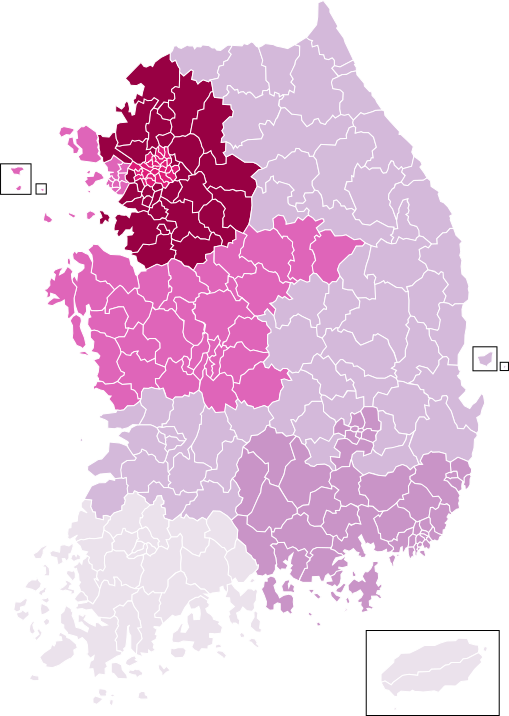

In [51]:
print("증가 광고주 수")
for item in glist1:
    #print(item['id'])
    if item['id'] not in 신규최종.index:
        continue
        
    count = 신규최종.loc[ item['id'], '광고주수' ]
    print(item['id'], " >> ", count)
    
    # 복지시설 수에 따라 단계값 설정 (단계는 색상값의 수에 따름)
    if count > 1500:   color_index = 6
    elif count > 1000: color_index = 5
    elif count > 150: color_index = 4
    elif count > 50: color_index = 3
    elif count > 30: color_index = 2
    elif count > 10: color_index = 1    
    else:            color_index = 1
    
    if item['id'] =='세종특별자치시':
        item['fill'] = colors1[color_index]
        continue
    # 현재 요소(item)의 하위 항목들에게 색상을 적용해야 한다.
    for p in item.select('g, path'):

        p['fill'] = colors1[color_index]
        
        
신규광고주전국지도svg = soup1.prettify()

SVG(신규광고주전국지도svg)

탈락 광고주 수
서울특별시  >>  1089
인천광역시  >>  189
경기도  >>  1421
강원도  >>  33
충청북도  >>  123
대전광역시  >>  136
충청남도  >>  125
제주특별자치도  >>  30
경상북도  >>  26
대구광역시  >>  69
울산광역시  >>  27
경상남도  >>  78
부산광역시  >>  90
전라북도  >>  37
광주광역시  >>  7
전라남도  >>  13
세종특별자치시  >>  63


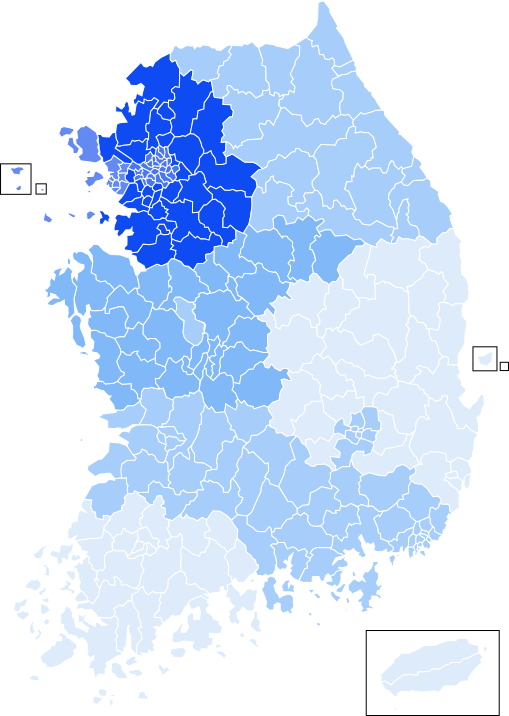

In [52]:
print("탈락 광고주 수")
for item in glist1:
    #print(item['id'])
    if item['id'] not in 탈락최종.index:
        continue
        
    count = 탈락최종.loc[ item['id'], '광고주수' ]
    print(item['id'], " >> ", count)
    
    # 복지시설 수에 따라 단계값 설정 (단계는 색상값의 수에 따름)
    if count > 1100:   color_index = 6
    elif count > 1000: color_index = 5
    elif count > 150: color_index = 4
    elif count > 100: color_index = 3
    elif count > 30: color_index = 2
    elif count > 10: color_index = 1    
    else:            color_index = 1
    
    if item['id'] =='세종특별자치시':
        item['fill'] = colors2[color_index]
        continue
    # 현재 요소(item)의 하위 항목들에게 색상을 적용해야 한다.
    for p in item.select('g, path'):

        p['fill'] = colors2[color_index]
        
        
탈락광고주전국지도svg = soup1.prettify()


SVG(탈락광고주전국지도svg)

In [53]:
결합리스트정리 = 결합리스트.filter(['구분','순번','상태','sido','종료구분','실제시작일','실제종료일'])
실제시작월리스트 = []
실제종료월리스트 = []
실제시작년리스트 = []
실제종료년리스트 = []

for i in range(len(list(결합리스트정리['실제시작일']))):
    실제시작월리스트.append(list(결합리스트정리['실제시작일'])[i][:7])
    실제종료월리스트.append(list(결합리스트정리['실제종료일'])[i][:7])
    실제시작년리스트.append(list(결합리스트정리['실제시작일'])[i][:4])
    실제종료년리스트.append(list(결합리스트정리['실제종료일'])[i][:4])
결합리스트정리['실제시작년'] = 실제시작년리스트
결합리스트정리['실제시작월'] = 실제시작월리스트
결합리스트정리['실제종료년'] = 실제종료년리스트
결합리스트정리['실제종료월'] = 실제종료월리스트
결합리스트정리['숫자'] = 1
print(결합리스트정리.shape)
결합리스트정리.head()


(19583, 12)


,구분,순번,상태,sido,종료구분,실제시작일,실제종료일,실제시작년,실제시작월,실제종료년,실제종료월,숫자
21,신규,335761,등록중,경기,결측,2020-05-15,2020-11-14,2020,2020-05,2020,2020-11,1
51,신규,334483,등록중,경기,결측,2020-05-07,2020-11-06,2020,2020-05,2020,2020-11,1
85,신규,332960,등록중,서울,결측,2020-04-24,2020-10-23,2020,2020-04,2020,2020-10,1
89,신규,348776,등록중,서울,결측,2020-08-28,2021-02-27,2020,2020-08,2021,2021-02,1
113,신규,333421,등록중,경기,결측,2020-04-28,2020-10-27,2020,2020-04,2020,2020-10,1


In [34]:
신규값 = 결합리스트정리.filter(['구분','실제시작년','실제시작월','숫자'])
신규값2 = 신규값.query('실제시작년 == "2020" and 구분 !="탈락"')
신규값3 = 신규값2.groupby(['실제시작월', '구분'], as_index=False).sum()
신규값4 = 신규값3.pivot('실제시작월','구분','숫자')


종료값 = 결합리스트정리.filter(['구분','실제종료년','실제종료월','숫자'])
종료값2 = 종료값.query('실제종료년 == "2020" and 구분 =="탈락" or 구분 == "신규탈락"' )
종료값3 = 종료값2.groupby(['실제종료월', '구분'], as_index=False).sum()
종료값4 = 종료값3.pivot('실제종료월','구분','숫자')


In [35]:
print(신규값3.shape)
신규값3.head()

(25, 3)


,실제시작월,구분,숫자
0,2020-01,신규,503
1,2020-01,신규탈락,183
2,2020-02,신규,401
3,2020-02,신규탈락,192
4,2020-03,신규,358


In [36]:
신규값4['탈락'] = 종료값4['탈락']
신규값4['신규탈락2'] = 종료값4['신규탈락']
신규값4.fillna(value = 0,inplace=True)
정리값=신규값4.reset_index()


In [37]:
정리값['총신규'] = 정리값['신규'] + 정리값['신규탈락']
정리값['총탈락'] = 정리값['탈락'] + 정리값['신규탈락2']
정리값.filter(['신규','신규탈락','실제유지','탈락','총신규','총탈락']).sum(axis=0)
정리값.rename(columns={'실제시작월' : '월구분'},inplace=True)




신규인덱스 = list(정리값['월구분'])
#회원본호 컬럼을 리스트로 추출
구인덱스 = list(정리값.index)

indexDict1={}
for i, v in enumerate(신규인덱스):
    before = 구인덱스[i];
    indexDict1[before] = v
정리값.drop(['월구분'], axis=1, inplace=True)
#drop전 데이터 출력
print(정리값.sum())

#drop 전각 합의 데이터 정리
신규합 = 정리값['신규'].sum()
신규탈락합 = 정리값['신규탈락'].sum()
실제유지합 = 정리값['실제유지'].sum()
탈락합 = 정리값['탈락'].sum()
tf용정리값 = 정리값.copy()
#drop
정리값.drop(['실제유지','신규탈락','신규탈락2'], axis=1, inplace=True)   
정리값.rename(index=indexDict1, inplace=True)


구분
신규        3815.0
신규탈락       711.0
실제유지     12212.0
탈락        2845.0
신규탈락2      711.0
총신규       4526.0
총탈락       3556.0
dtype: float64


<AxesSubplot:xlabel='구분'>

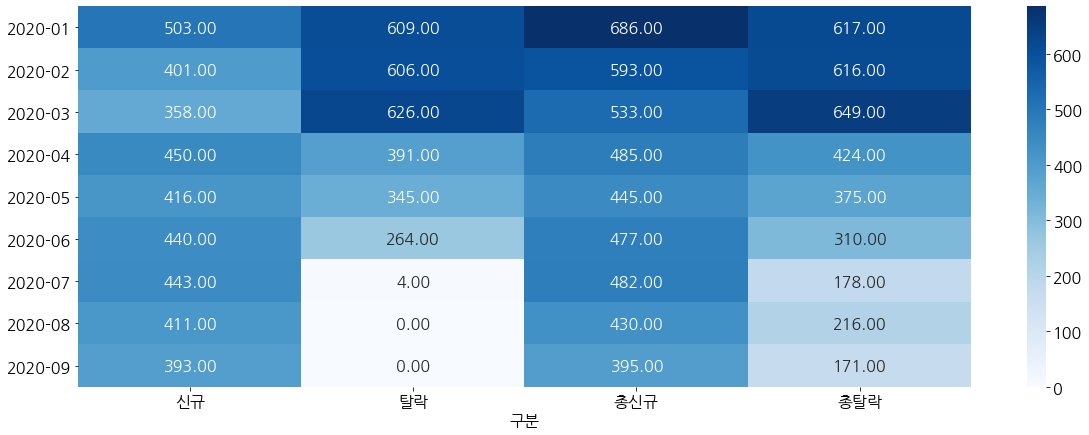

In [38]:
#정리값 확인 히트맵
# 한글폰트, 그래픽 크기 설정
pyplot.rcParams["font.family"] = 'NanumGothic'
pyplot.rcParams["font.size"] = 16
pyplot.rcParams["figure.figsize"] = (40, 30)

pyplot.figure(figsize=(20,7))
sns.heatmap(정리값, annot=True, fmt=".2f", cmap="Blues")

In [39]:
#정리값 기초통계 확인
정리값.describe()

구분,신규,탈락,총신규,총탈락
count,9.000000,9.000000,9.000000,9.000000
mean,423.888889,316.111111,502.888889,395.111111
std,41.250589,267.459083,89.642965,193.782381
min,358.000000,0.000000,395.000000,171.000000
25%,401.000000,4.000000,445.000000,216.000000
50%,416.000000,345.000000,482.000000,375.000000
75%,443.000000,606.000000,533.000000,616.000000
max,503.000000,626.000000,686.000000,649.000000


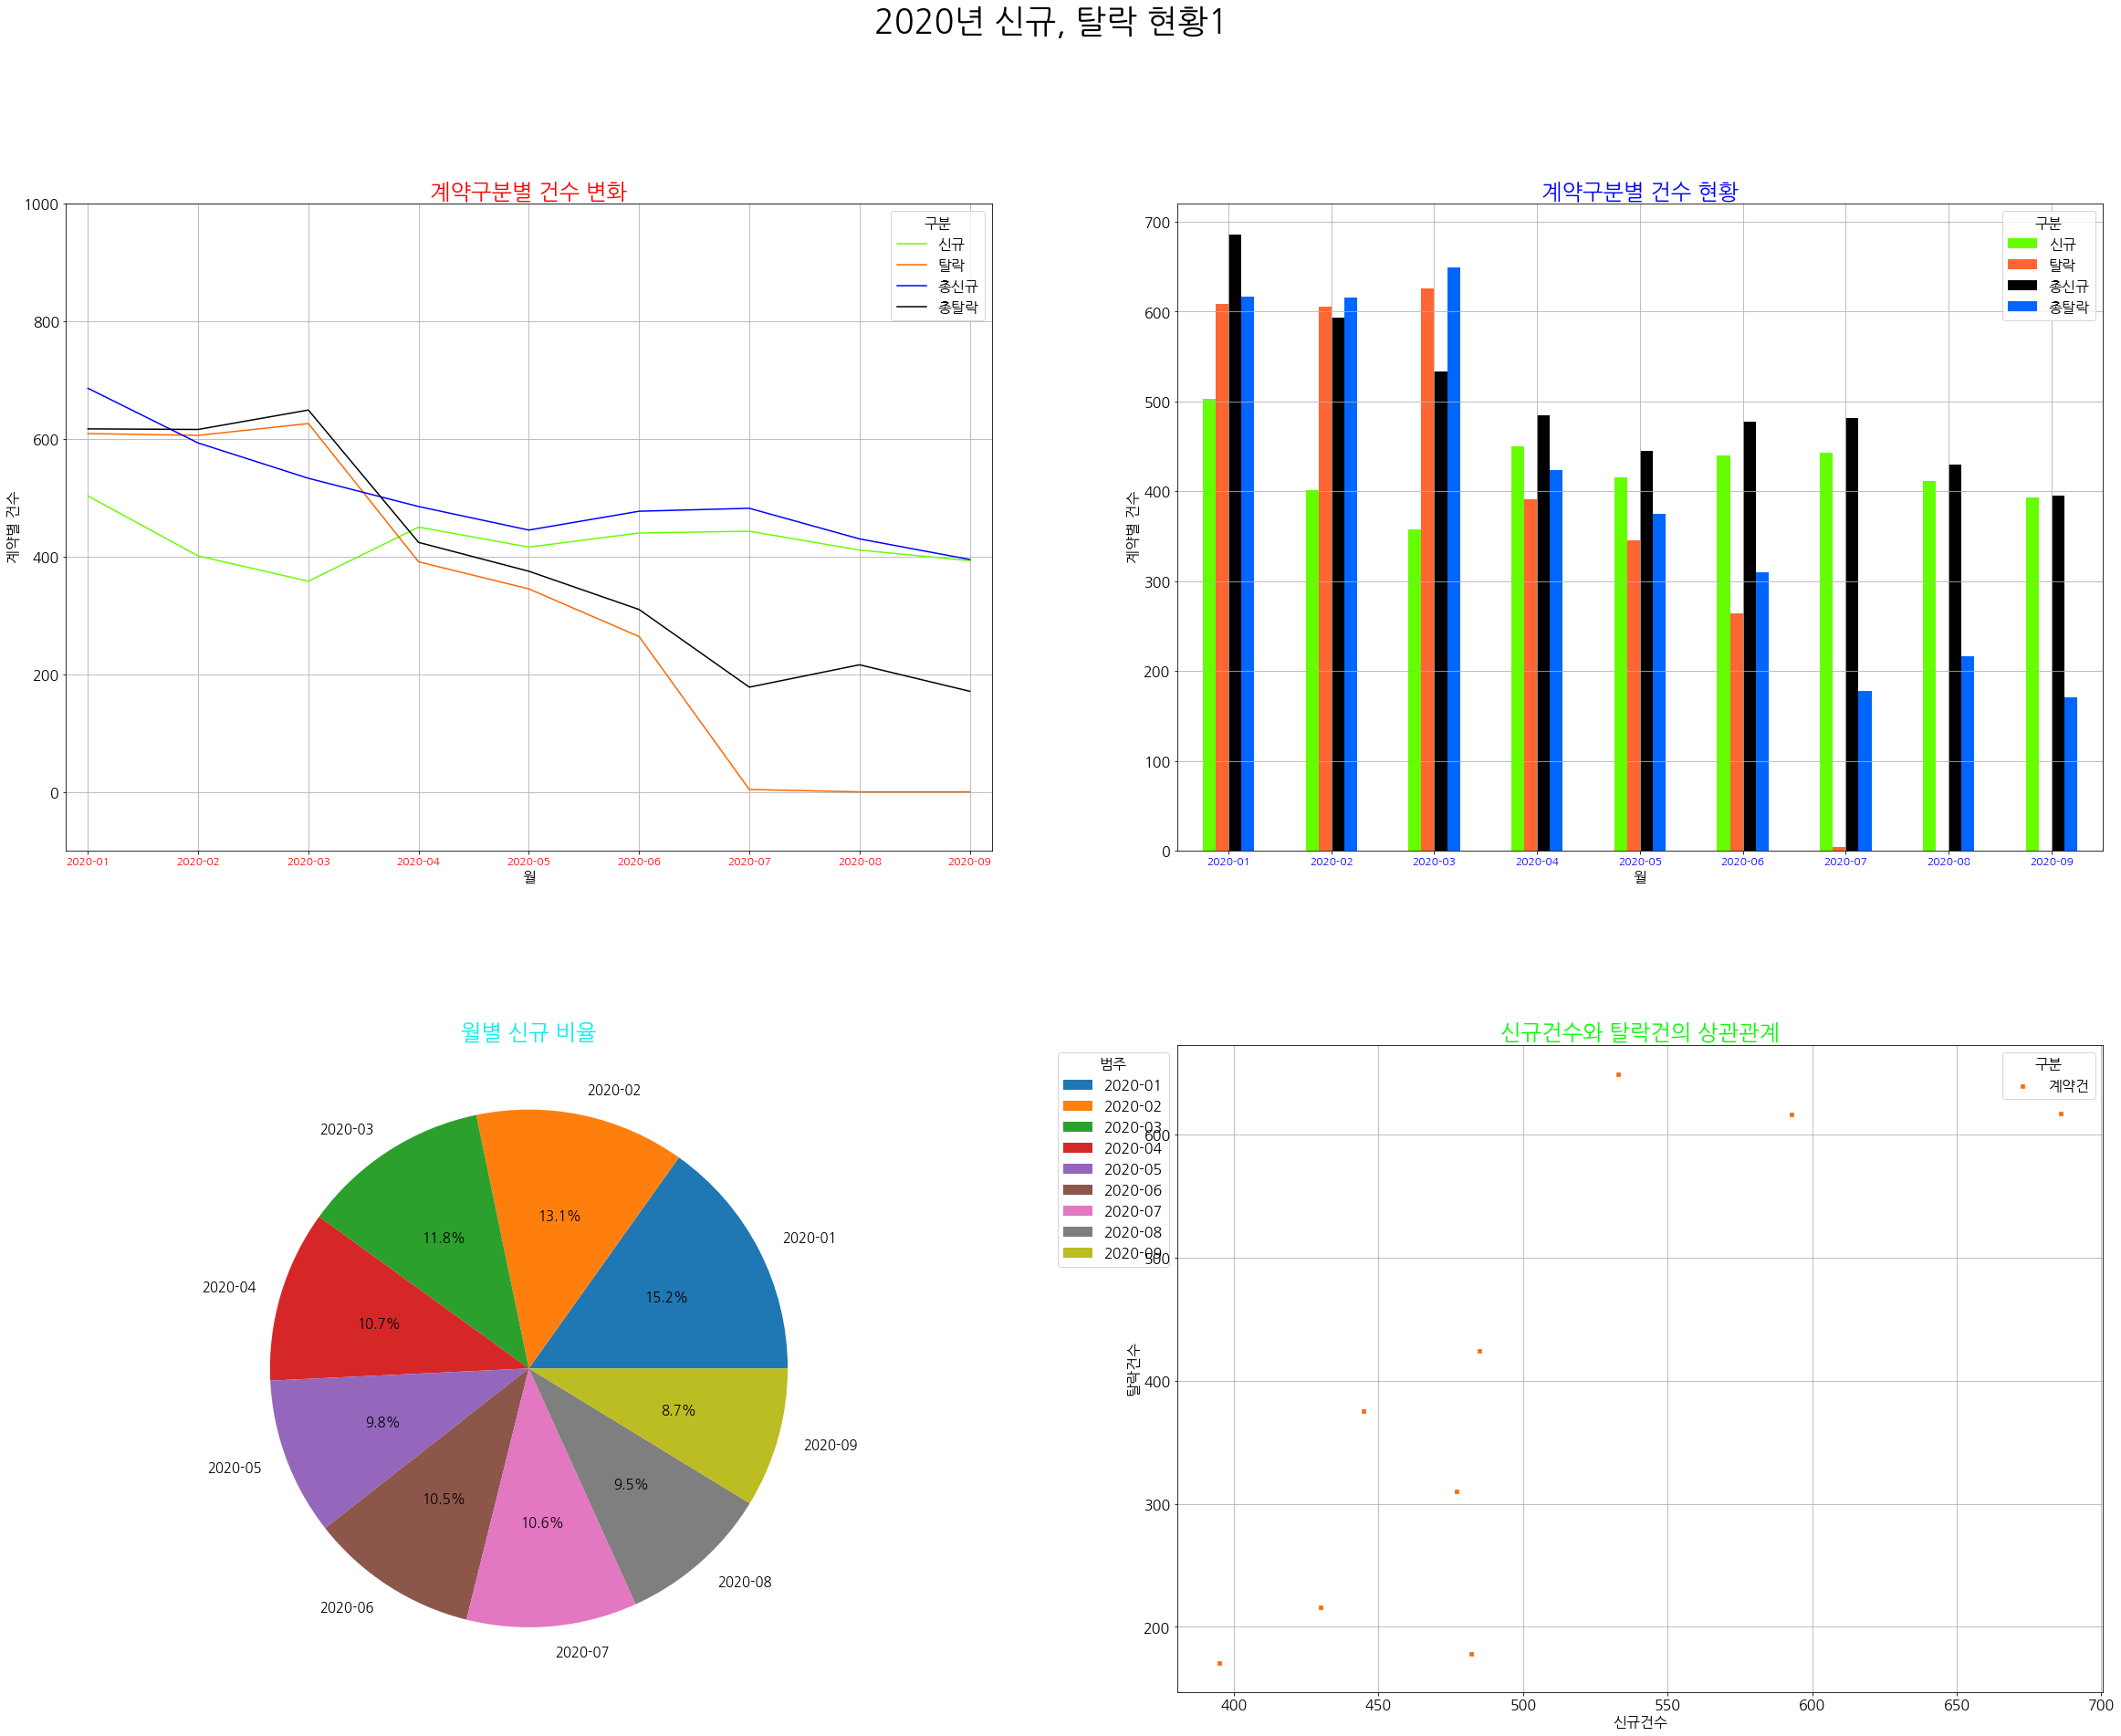

In [40]:
#경로설정
os.chdir("/Users/donut/더비즈/광고주수증가/saved_data")


# 4행 2열의 영역을 생성
fig = pyplot.figure()           # 영역을 나눌 수 있는 객체 생성
ax1 = fig.add_subplot(2, 2, 1)  # 2행 2열의 영역 중에서 첫 번째 영역
ax2 = fig.add_subplot(2, 2, 2)  # 2행 2열의 영역 중에서 두 번째 영역
ax3 = fig.add_subplot(2, 2, 3)  # 2행 2열의 영역 중에서 세 번째 영역
ax4 = fig.add_subplot(2, 2, 4)  # 2행 2열의 영역 중에서 네 번째 영역


# 전체 제목
fig.suptitle('2020년 신규, 탈락 현황1', fontsize=36, color='#000000')

# 각 그래프 간의 가로(wspace),세로(hspace) 간격 지정
fig.subplots_adjust(wspace=0.2, hspace=0.3)

#--------------------------------------------------------------
# 첫 번째 영역 그래프 표시
#--------------------------------------------------------------
# 선 그래프 표시
정리값.plot(ax=ax1, color=['#66ff00', '#ff6600', '#0000ff', '#000000' ])

# 배경 격자 표시
ax1.grid()

# 그래프 제목의 텍스트, 글자크기, 색상
ax1.title.set_text("계약구분별 건수 변화")
ax1.title.set_fontsize(24)
ax1.title.set_color('#ff0000')

# pyplot을 직접 사용할 경우 xticks(x축좌표, 표시할_텍스트) 형식으로 지정하지만
# 서브플롯은 x축의 좌표와 표시할 텍스트를 나누어서 처리한다.
# -> x축의 좌표만 지정함
start = 0
end = 9
ax1.set_xticks(list(range(start, end)))

# -> 지정된 x축 좌표에 표시될 텍스트 리스트를 지정함.
ax1.set_xticklabels(정리값.index, fontsize=12, color='#ff0000')

# x축과 y축의 라벨을 지정 (불필요한 부분은 생략 가능)
ax1.set(xlabel='월', ylabel='계약별 건수')

# x축, y축의 범위
ax1.set_xlim([start-0.2, end-0.8])
ax1.set_ylim([-100, 1000])

#--------------------------------------------------------------
# 두 번째 영역 그래프 표시
#--------------------------------------------------------------
# 막대 그래프 표시
# -> x축의 텍스트가 90도로 표시되므로 rot 파라미터를 사용하여 0도로 재지정
# -> 데이터프레임의 각 컬럼에 대한 색상 지정
정리값.plot.bar(ax=ax2, rot=0, color=['#66ff00','#ff6633', '#000000', '#0066ff'])

# 배경 격자 표시
ax2.grid()

# 그래프 제목의 텍스트, 글자크기, 색상
ax2.title.set_text("계약구분별 건수 현황")
ax2.title.set_fontsize(24)
ax2.title.set_color('#0000ff')

# x축의 좌표만 지정함 (막대그래프의 경우 x축 좌표는 무조건 0부터 시작함)
ax2.set_xticks(list(range(0, len(정리값))))
# 지정된 x축 좌표에 표시될 텍스트 리스트를 지정함.
ax2.set_xticklabels(정리값.index, fontsize=12, color='#0000ff')

# x축과 y축의 라벨을 지정 (불필요한 부분은 생략 가능)
ax2.set(xlabel='월', ylabel='계약별 건수')

#--------------------------------------------------------------
# 세 번째 영역 그래프 표시
#--------------------------------------------------------------
# 월별 신규 파이그래프
정리값['총신규'].plot.pie(ax=ax3, labels=정리값.index, autopct="%0.1f%%", textprops={'color':"#000000", 'fontsize': 15})

# 그래프 제목
ax3.title.set_text("월별 신규 비율")
ax3.title.set_fontsize(24)
ax3.title.set_color('#00f0f0')
# 격자표시 --> 파이그래프인 경우는 표시 안됨
ax3.grid()

# y축 라벨이 불필요하므로 제거
ax3.set(ylabel=None)

# 범주 표시
ax3.legend(labels=정리값.index, title='범주', bbox_to_anchor=(1.5, 1))

#--------------------------------------------------------------
# 네 번째 영역 그래프 표시
#--------------------------------------------------------------
# 산점도 그래프
정리값.plot.scatter(ax=ax4, x='총신규', y='총탈락', color='#ff6600', marker='X', label='계약건')

# 그래프 제목 지정
ax4.title.set_text("신규건수와 탈락건의 상관관계")
ax4.title.set_fontsize(24)
ax4.title.set_color('#00ff00')

# 배경 격자
ax4.grid()

# x축 라벨
ax4.set(xlabel='신규건수', ylabel='탈락건수')

#--------------------------------------------------------------
# 그래프 출력하기
#--------------------------------------------------------------

pyplot.savefig('%s-%s-%s 시각화자료1.png'%(now.year, now.month, now.day))
pyplot.show()


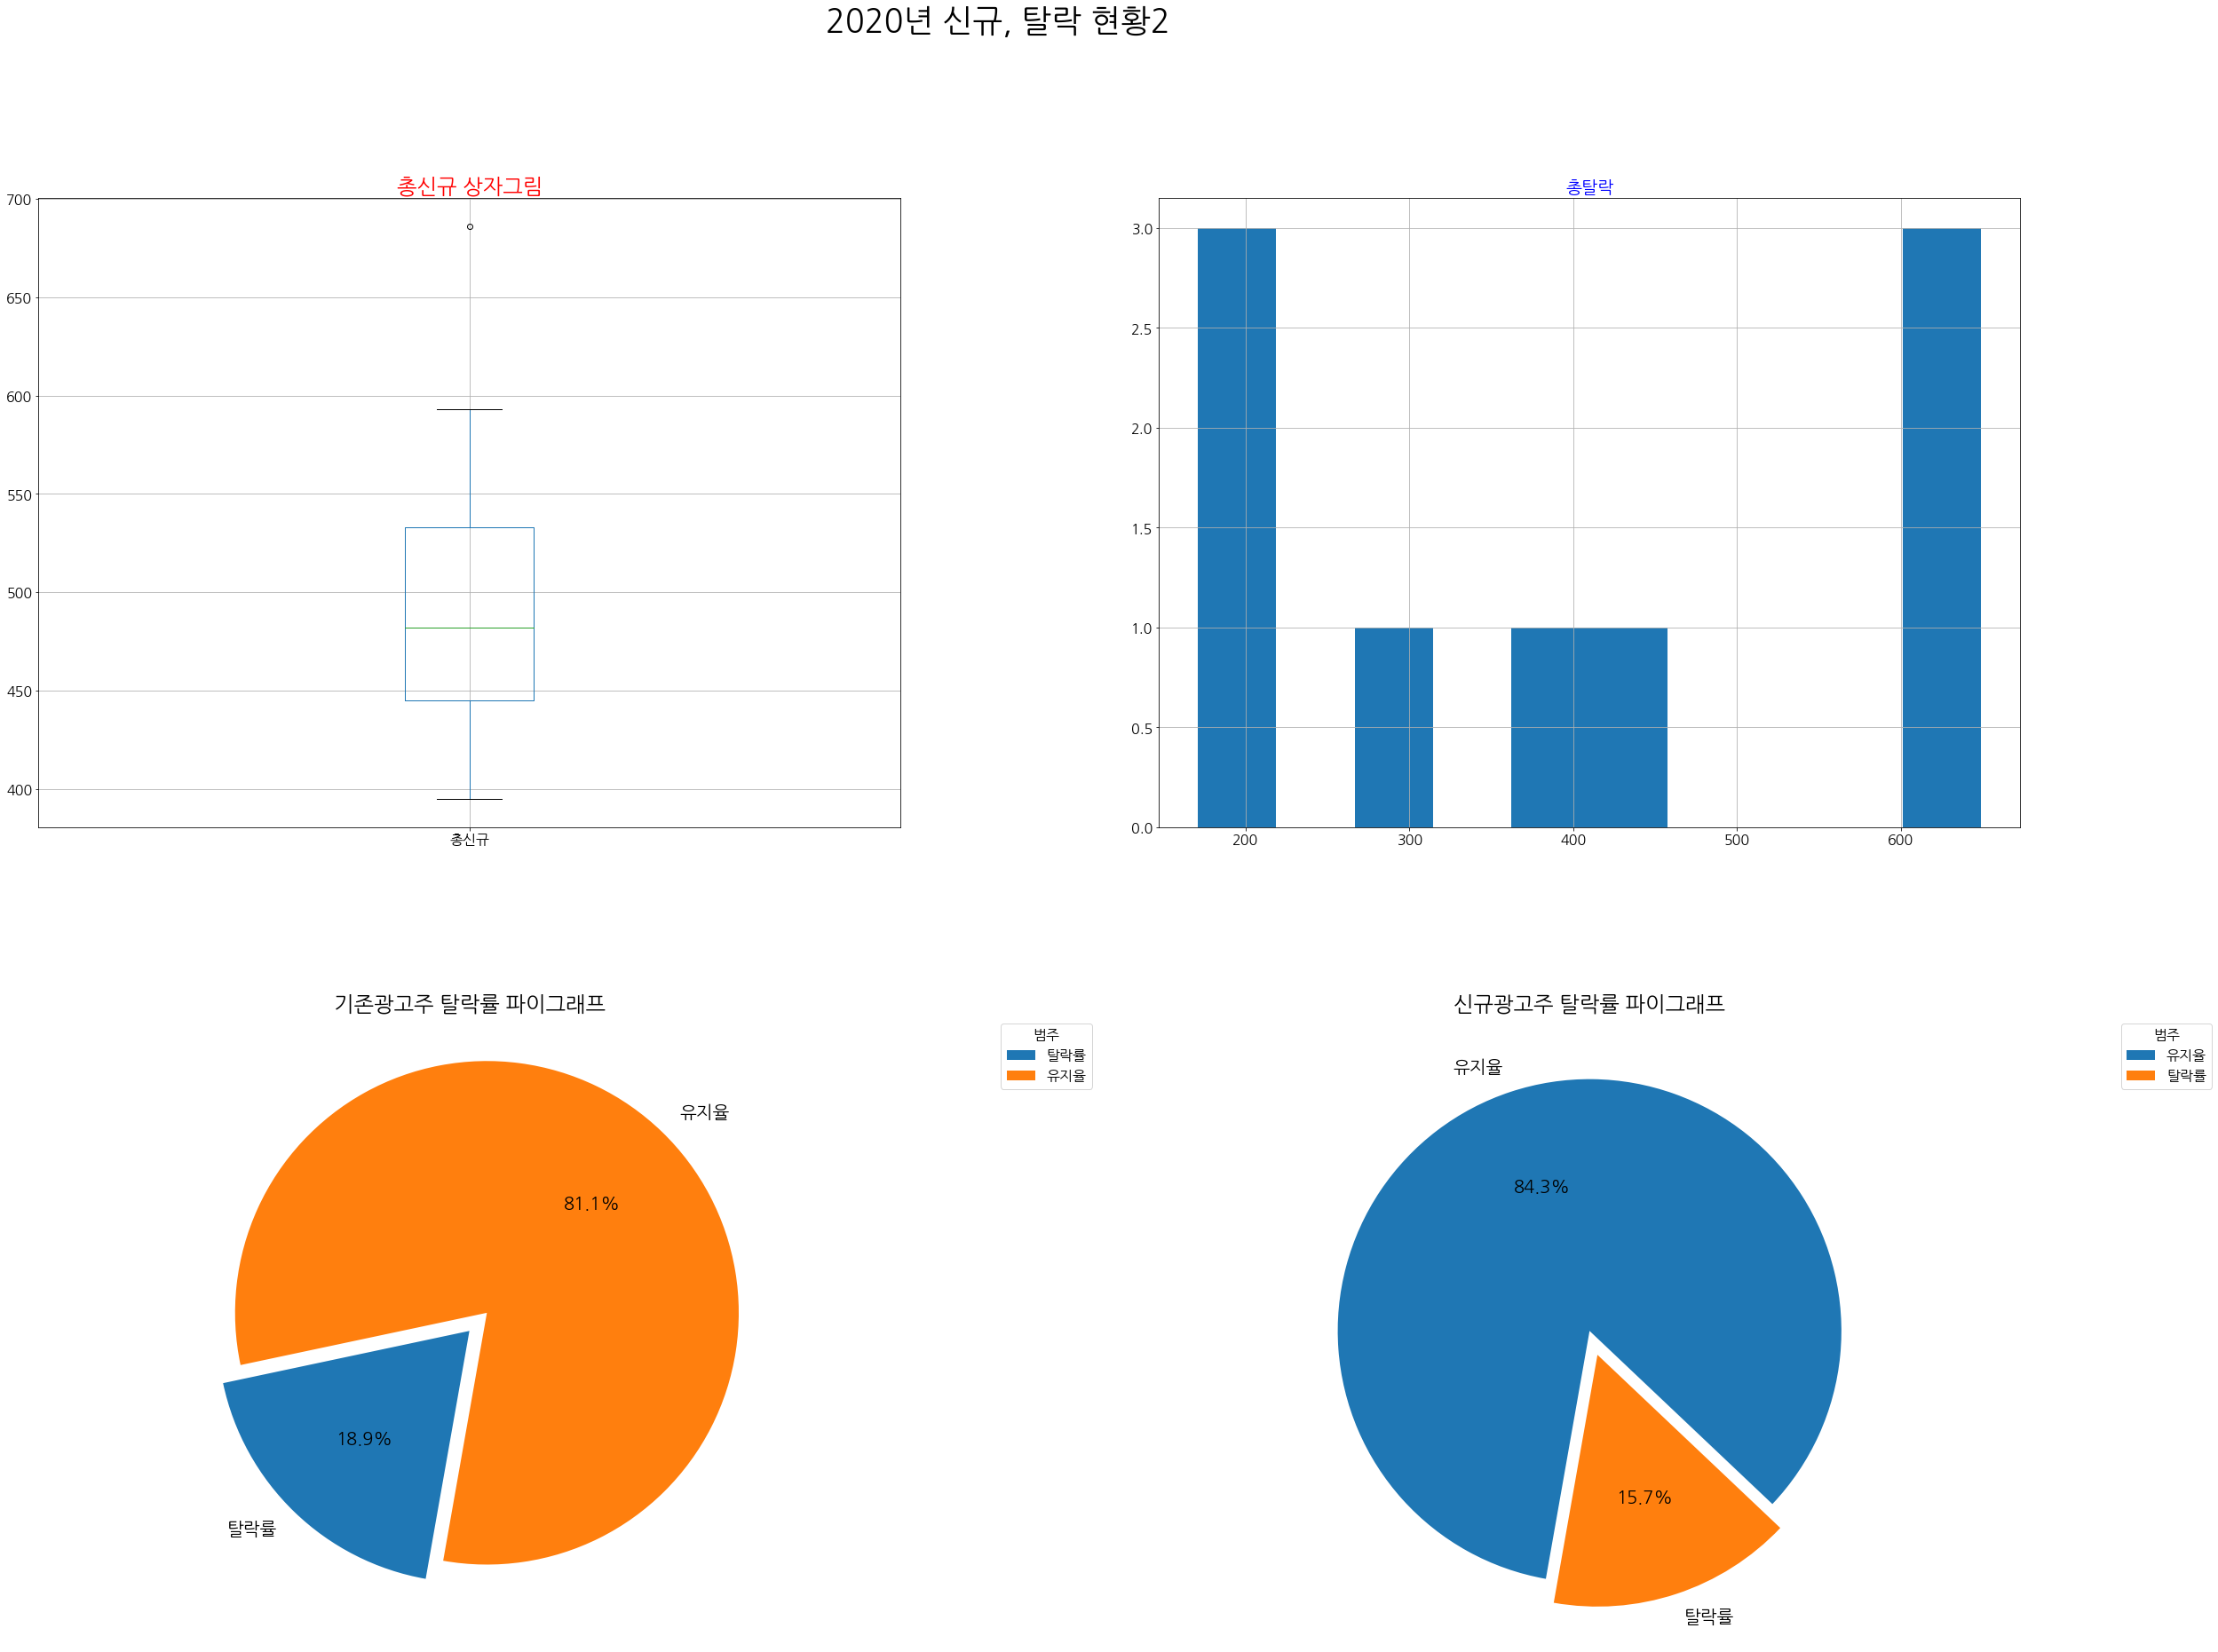

In [41]:
fig = pyplot.figure()           # 영역을 나눌 수 있는 객체 생성
ax5 = fig.add_subplot(2, 2, 1)  # 2행 2열의 영역 중에서 첫 번째 영역
ax6 = fig.add_subplot(2, 2, 2)  # 2행 2열의 영역 중에서 둘 번째 영역
ax7 = fig.add_subplot(2, 2, 3)  # 2행 2열의 영역 중에서 셋 번째 영역
ax8 = fig.add_subplot(2, 2, 4)  # 2행 2열의 영역 중에서 넷 번째 영역

# 전체 제목
fig.suptitle('2020년 신규, 탈락 현황2', fontsize=36, color='#000000')

# 각 그래프 간의 가로(wspace),세로(hspace) 간격 지정
fig.subplots_adjust(wspace=0.2, hspace=0.3)


#--------------------------------------------------------------
# 다섯 번째 영역 그래프 표시
#--------------------------------------------------------------
#총신규 상자그림
ax5.title.set_text("총신규 상자그림")
ax5.title.set_fontsize(24)
ax5.title.set_color('#ff0000')
정리값.boxplot(['총신규'], ax=ax5)

#--------------------------------------------------------------
# 여섯 번째 영역 그래프 표시
#--------------------------------------------------------------
#총탈락 상자그림
ax6.title.set_text("총탈락 히스토그램")
ax6.title.set_fontsize(24)
ax6.title.set_color('#0000ff')
정리값.hist(['총탈락'], ax=ax6)


#--------------------------------------------------------------
# 일곱 번째 영역 그래프 표시
#--------------------------------------------------------------
#탈락률 파이 그래프

ax7.title.set_text("기존광고주 탈락률 파이그래프")
ax7.title.set_fontsize(24)

ratio = [탈락합,실제유지합]
df = DataFrame(ratio)
labels = ['탈락률', '유지율']
explode = [0, 0.10]
df.plot.pie(ax=ax7, labels=labels, autopct='%.1f%%',subplots=True,
            textprops={'color':"#000000", 'fontsize': 20},
           startangle=260, counterclock=False, explode=explode)
ax7.legend(labels=labels, title='범주', bbox_to_anchor=(1.5, 1))
ax7.set(ylabel=None)
#--------------------------------------------------------------
# 여덟 번째 영역 그래프 표시
#--------------------------------------------------------------
ax8.title.set_text("신규광고주 탈락률 파이그래프")
ax8.title.set_fontsize(24)

ratio = [신규합,신규탈락합]
df = DataFrame(ratio)
labels = ['유지율', '탈락률']
explode = [0, 0.10]
df.plot.pie(ax=ax8, labels=labels, autopct='%.1f%%',subplots=True,
            textprops={'color':"#000000", 'fontsize': 20},
           startangle=260, counterclock=False, explode=explode)
ax8.legend(labels=labels, title='범주', bbox_to_anchor=(1.5, 1))
ax8.set(ylabel=None)

#--------------------------------------------------------------
# 그래프 출력하기
#--------------------------------------------------------------

pyplot.savefig('%s-%s-%s 시각화자료2.png'%(now.year, now.month, now.day))
pyplot.show()

## 피어슨 상관계수에 따른 분석
피어슨 상관계수를 구하여, 신규와 탈락간의 관계를 파악하기

In [42]:
cor = numpy.corrcoef(정리값['총신규'],정리값['총탈락'])
[[a,b],[c,d]]= cor
cor2 = str(c)[2:4]

print("상관계수는 : " ,int(cor2)/100 ,"입니다")

if int(cor2)/10 >= 7:
    print("강한 양적 선형관계")
elif int(cor2)/10 >= 3:
    print("뚜렷한 양적 선형관계")
elif int(cor2)/10 >= 1:
    print("약한 양적 선형관계")
elif int(cor2)/10 >= -1:
    print("무시될 수있는 선형관계")
elif int(cor2)/10 >= -3:
    print("약한 음적 선형관계")
elif int(cor2)/10 >= -7:
    print("뚜렷한 음적 선형관계")
else:
    print("강한 음적 선형관계")
    

상관계수는 :  0.81 입니다
강한 양적 선형관계


## 신규건수에 따른 탈락건수 예측 텐서플로우
데이터 입력,초기값설정, 경사하강법 사용

In [43]:
tf용정리값.head(2)

구분,신규,신규탈락,실제유지,탈락,신규탈락2,총신규,총탈락
0,503.0,183.0,0.0,609.0,8.0,686.0,617.0
1,401.0,192.0,0.0,606.0,10.0,593.0,616.0


데이터세팅 및 확인

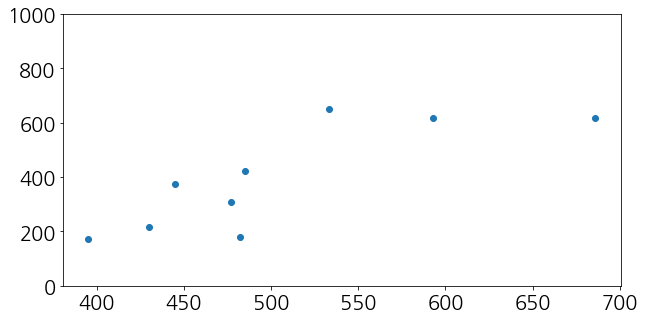

In [44]:
pyplot.rcParams["font.family"] = 'NanumGothic'
pyplot.rcParams["font.size"] = 20
pyplot.rcParams["figure.figsize"] = (10, 5)
x_data = tf용정리값['총신규']
y_data = tf용정리값['총탈락']
pyplot.plot(x_data, y_data, 'o')
pyplot.ylim(0,1000)

pyplot.show()

#### 초기값 설정 및 가설값 확인
초기값에 의한 가설값 선형그래프로 표시,   
텐서플로우 단순선형회귀로 가장 cost(오차율) 낮은 가설 찾기.


In [45]:
#W,b는 랜덤값으로로 설정이 가능함
W = tf.Variable(1.0)
b = tf.Variable(0.5)

#y=Wx + b
hypothesis = W * x_data+b
hypothesis.numpy()

array([686.5, 593.5, 533.5, 485.5, 445.5, 477.5, 482.5, 430.5, 395.5],
      dtype=float32)

####  초기값에 의한 그래프 파악

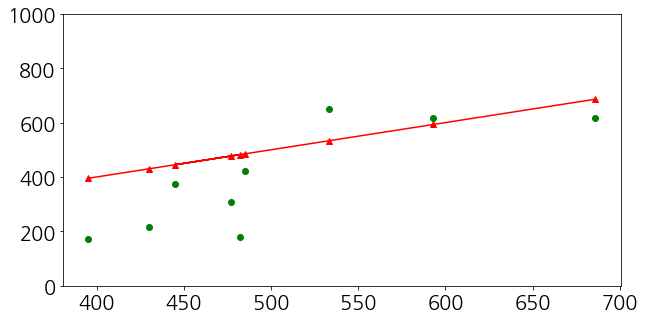

In [46]:
#그래프로 확인하기
#빨간선(선형)에 표시된 값은 이번에 구한 가설(y = hypothesis)이다.
#저 선형그래프를 초기 초기 데이터에 가장 근사하게 그려질 수있도록 만들어 줄 것이다.
pyplot.plot(x_data, hypothesis.numpy(), 'r-^')
pyplot.plot(x_data, y_data, 'go')
pyplot.ylim(0, 1000)
pyplot.show()

## 단순선형회귀 로 예측하기
다만 x, y값이 다소 크기 때문에 표준화 기법으로 스케일을 맞추었음.   
사이킷런의 StandardScaler를 사용.  




학습횟수|   W값   |   b값   | 오차율 
    0|   0.9962|   0.0980|  0.386624
  100|   0.8362|   0.0130|  0.341962
  200|   0.8149|   0.0017|  0.341177
  300|   0.8121|   0.0002|  0.341163
  400|   0.8117|   0.0000|  0.341163
  500|   0.8117|   0.0000|  0.341163
  600|   0.8117|   0.0000|  0.341163
  700|   0.8117|   0.0000|  0.341163
  800|   0.8117|   0.0000|  0.341163
  900|   0.8117|  -0.0000|  0.341163
 1000|   0.8117|  -0.0000|  0.341163


(-2.0, 4.0)

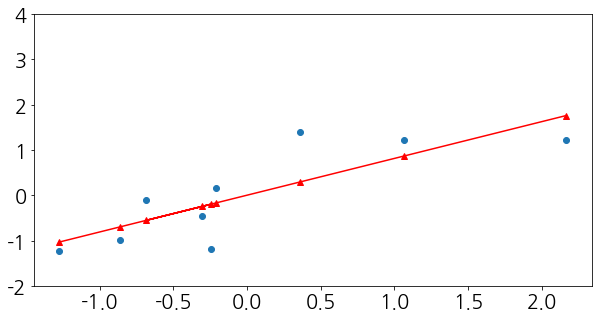

In [47]:
stdsc = StandardScaler()
x_data = tf용정리값['총신규']
y_data = tf용정리값['총탈락']

x_std = stdsc.fit_transform(numpy.array(x_data).reshape(-1,1))
y_std = stdsc.fit_transform(numpy.array(y_data).reshape(-1,1))

W = tf.Variable(1.0)
b = tf.Variable(0.1)
#learning_rate =학습률
learning_rate = 0.01
print("학습횟수|   W값   |   b값   | 오차율 ")

for i in range(1001):
    with tf.GradientTape() as tape:
        hypothesis = W * x_std + b
        cost = tf.reduce_mean(tf.square(hypothesis - y_std))
    W_grad, b_grad = tape.gradient(cost, [W, b])
    W.assign_sub(learning_rate * W_grad)
    b.assign_sub(learning_rate * b_grad)
    if i % 100 == 0:
        print("{:5}|{:9.4f}|{:9.4f}|{:10.6f}".format(i, W.numpy(), b.numpy(), cost))

pyplot.rcParams['axes.unicode_minus'] = False    
pyplot.plot(x_std, y_std, 'o')
pyplot.plot(x_std, hypothesis.numpy(), 'r-^')
pyplot.ylim(-2, 4)

In [48]:
print("신규건수가 550건 일때")
a=550
탈락예측값 = (W * (a/100) + b)*100

print("탈락건수가 %d건으로 예측됩니다."%탈락예측값)

신규건수가 550건 일때
탈락건수가 446건으로 예측됩니다.
